In [2]:
%%capture
!pip install diffusers["torch"] transformers

In [ ]:
import torch

torch.cuda.empty_cache()

In [3]:
import torch
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())

def numpy_to_image(np_array):
    return Image.fromarray((np_array * 255).astype(np.uint8))

def plot_images(original, denoised, residual, step):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(original)
    axes[0].set_title(f"Original (Step {step})")
    axes[1].imshow(denoised)
    axes[1].set_title(f"Denoised (Step {step})")
    axes[2].imshow(residual)
    axes[2].set_title(f"Residual (Step {step})")
    for ax in axes:
        ax.axis('off')
    plt.show()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/diffusers/schedulers/scheduling_lms_discrete.py:21: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.22.4)
  from scipy import integrate


In [4]:
# Load the Stable Diffusion pipeline
model_id = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
pipe = pipe.to("cuda")


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# Set up the denoising process
prompt = "A beautiful landscape with mountains and a lake"
num_inference_steps = 50
guidance_scale = 7.5

# Generate the initial latents
latents = torch.randn(
    (1, pipe.unet.in_channels, pipe.unet.sample_size, pipe.unet.sample_size),
    device=pipe.device,
    dtype=torch.float
)

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps)

# Text embeddings
text_embeddings = pipe._encode_prompt(prompt, device=pipe.device, num_images_per_prompt=1, do_classifier_free_guidance=True)

/tmp/ipykernel_6491/293235949.py:8: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (1, pipe.unet.in_channels, pipe.unet.sample_size, pipe.unet.sample_size),
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:283: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


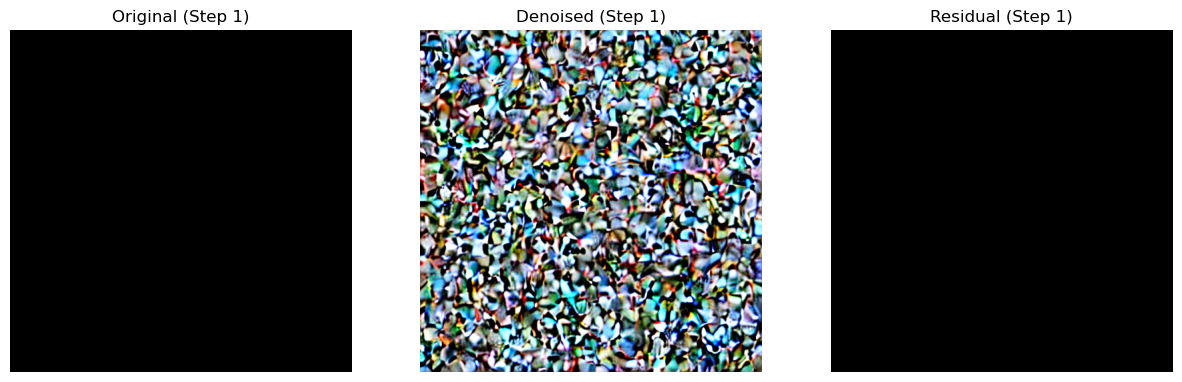

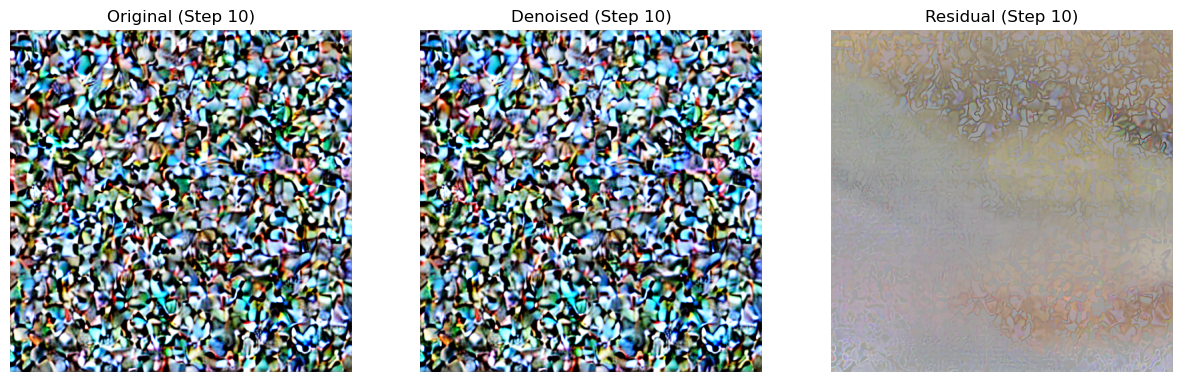

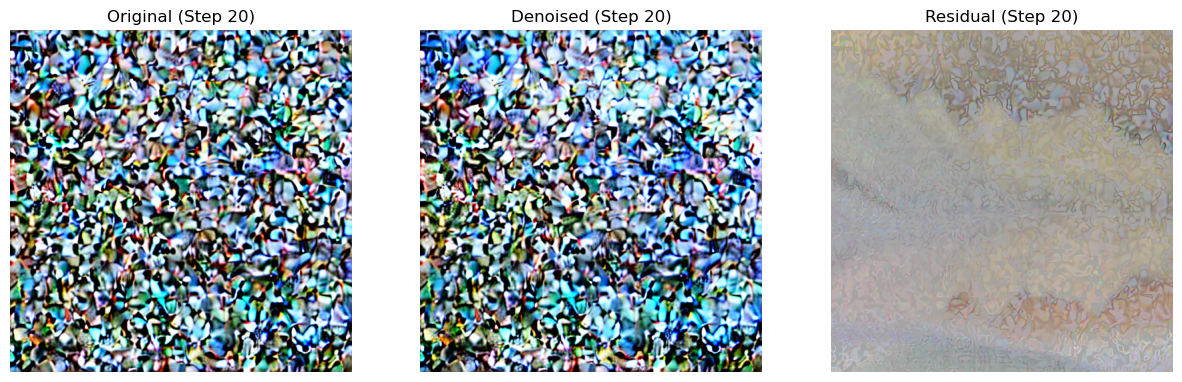

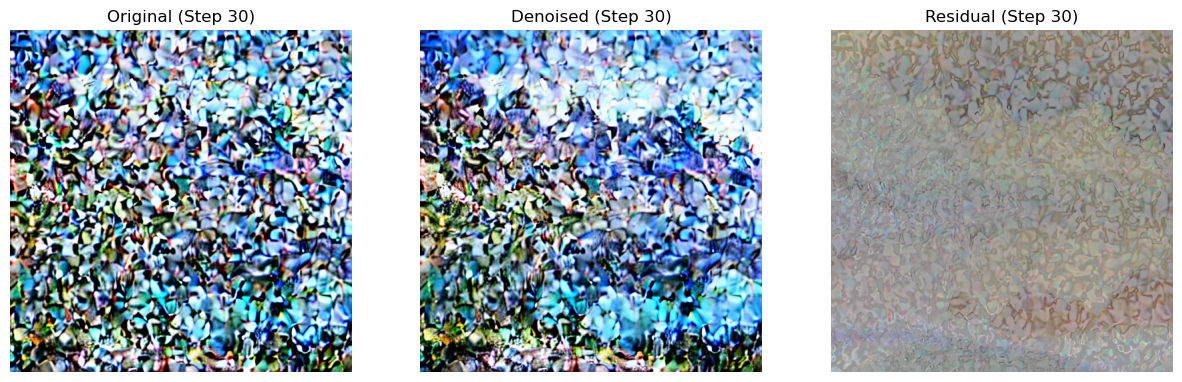

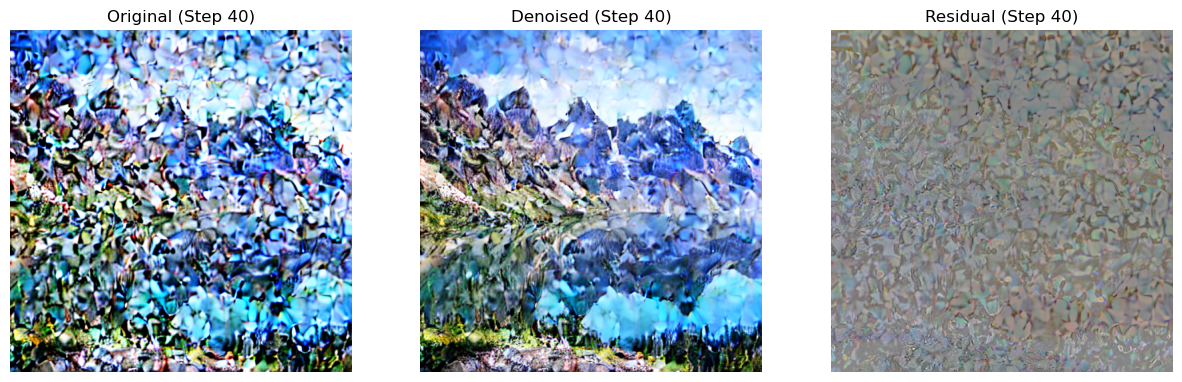

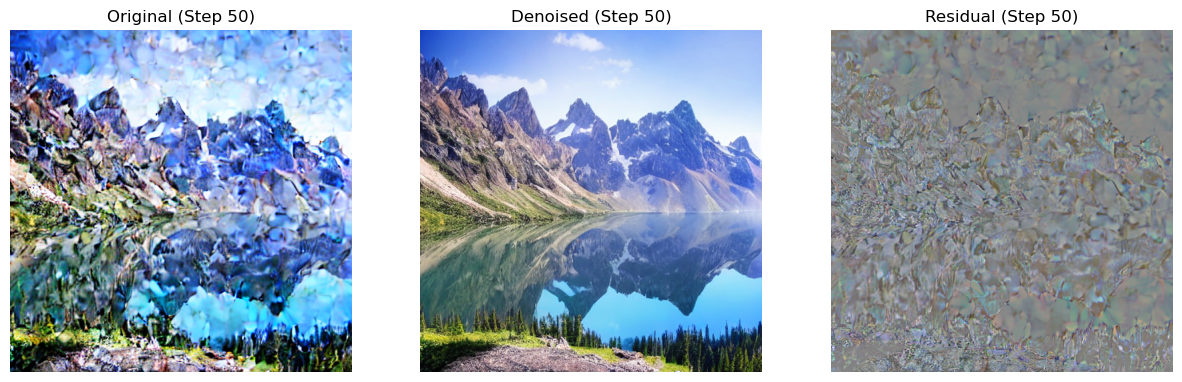

In [6]:
# Denoising loop
for i, t in enumerate(pipe.scheduler.timesteps):
    # Expand the latents for classifier free guidance
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    # Visualize the intermediate results
    if (i + 1) % 10 == 0 or i == 0 or i == num_inference_steps - 1:
        # Decode the current latents
        with torch.no_grad():
            image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]

        # Convert to numpy and normalize
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
        
        # Compute the residual
        if i > 0:
            residual = normalize_image(previous_image - image)
        else:
            residual = np.zeros_like(image)

        # Visualize
        plot_images(normalize_image(previous_image) if i > 0 else np.zeros_like(image),
                    normalize_image(image),
                    residual,
                    i + 1)

        previous_image = image.copy()



In [ ]:
# Final image
final_image = Image.fromarray((image * 255).astype(np.uint8))
final_image.save("final_image.png")
print("Final image saved as 'final_image.png'")

In [ ]:
# Denoising loop
for i, t in enumerate(pipe.scheduler.timesteps):
    # Expand the latents for classifier free guidance
    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    # Visualize the intermediate results
    if (i + 1) % 10 == 0 or i == 0 or i == num_inference_steps - 1:
        # Decode the current latents
        with torch.no_grad():
            image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]

        # Convert to numpy and normalize
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
        
        # Compute the residual
        if i > 0:
            residual = normalize_image(previous_image - image)
        else:
            residual = np.zeros_like(image)

        # Visualize
        plot_images(normalize_image(previous_image) if i > 0 else np.zeros_like(image),
                    normalize_image(image),
                    residual,
                    i + 1)

        previous_image = image.copy()
